трансформируем массив нампай из датасета в тензоры для дальнейшего обучения нейросети

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

PyTorch Dataloader — это служебный класс, разработанный для упрощения загрузки и итерации по наборам данных при обучении моделей глубокого обучения. Он имеет различные ограничения для итерации наборов данных, такие как пакетирование, перемешивание и обработка данных
Также пишу простой класс для нейросети унаследованный от стандартной модели пайторч. 

In [18]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()  
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),   
            nn.ReLU(),   
            nn.Dropout(0.2),             

            nn.Linear(512, 256),         
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 10)    
        )

    def forward(self, x):
        x = self.flatten(x)             
        logits = self.linear_relu_stack(x)
        return logits

model = SimpleNN()

Произошла одна эпоха (epoch) — весь датасет прошел через нейронную сеть в прямом и обратном направлении только один раз.

Так как одна эпоха слишком велика для используемой вычислительной мощности, датасет делят на маленькие партии — батчи.

Почему мы используем более одной эпохи
Вначале не понятно, почему недостаточно одного полного прохода датасета через нейронную сеть, и почему необходимо пускать полный датасет по сети несколько раз.

Нужно помнить, что мы используем ограниченный датасет, чтобы оптимизировать обучение и подстроить кривую под данные. Делается это с помощью градиентного спуска — итеративного процесса. Поэтому обновления весов после одного прохождения недостаточно.
Размер батча — это общее число тренировочных объектов, представленных в одном батче.

Отметим: Размер батча и число батчей — два разных параметра.

Что такое батч?
Нельзя пропустить через нейронную сеть разом весь датасет. Поэтому делим данные на пакеты, сеты или партии, так же, как большая статья делится на много разделов — введение, градиентный спуск, эпохи, Batch size и итерации. Такое разбиение позволяет легче прочитать и понять статью.
Итерации
Итерации — число батчей, необходимых для завершения одной эпохи.

Отметим: число батчей равно числу итераций для одной эпохи.

In [19]:
loss_fn = nn.CrossEntropyLoss()           
optimizer = optim.Adam(model.parameters())

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
    
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

epochs = 3
for t in range(epochs):
    train(train_loader, model, loss_fn, optimizer)


loss: 2.295039  [   32/60000]
loss: 0.985993  [ 3232/60000]
loss: 0.560425  [ 6432/60000]
loss: 0.303056  [ 9632/60000]
loss: 0.479208  [12832/60000]
loss: 0.192748  [16032/60000]
loss: 0.151004  [19232/60000]
loss: 0.204267  [22432/60000]
loss: 0.088533  [25632/60000]
loss: 0.248018  [28832/60000]
loss: 0.169895  [32032/60000]
loss: 0.253147  [35232/60000]
loss: 0.306009  [38432/60000]
loss: 0.075808  [41632/60000]
loss: 0.019181  [44832/60000]
loss: 0.029778  [48032/60000]
loss: 0.467229  [51232/60000]
loss: 0.435195  [54432/60000]
loss: 0.069487  [57632/60000]
loss: 0.093260  [   32/60000]
loss: 0.093719  [ 3232/60000]
loss: 0.099129  [ 6432/60000]
loss: 0.161228  [ 9632/60000]
loss: 0.012441  [12832/60000]
loss: 0.104086  [16032/60000]
loss: 0.138072  [19232/60000]
loss: 0.082151  [22432/60000]
loss: 0.058729  [25632/60000]
loss: 0.156536  [28832/60000]
loss: 0.057394  [32032/60000]
loss: 0.070711  [35232/60000]
loss: 0.048362  [38432/60000]
loss: 0.013149  [41632/60000]
loss: 0.14

Смотрим метрики

In [20]:
size = len(test_loader.dataset)
num_batches = len(test_loader)
model.eval()
test_loss, correct = 0, 0
with torch.no_grad():
    for X, y in test_loader:
        pred = model(X)
        test_loss += loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
test_loss /= num_batches
correct /= size
print(f"Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


Accuracy: 97.8%, Avg loss: 0.073519 



Правильные предсказания:


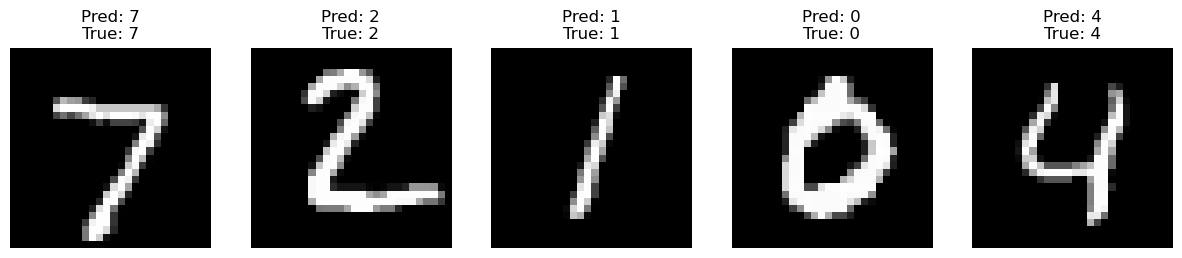

Ошибочные предсказания:


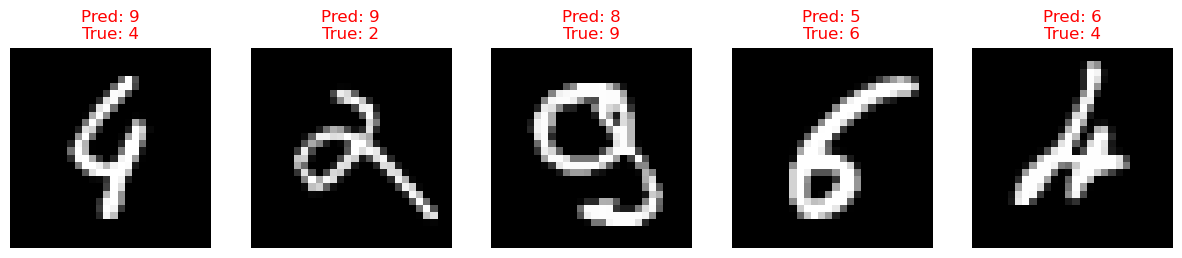

In [21]:
model.eval()

correct_images = []
incorrect_images = []
correct_labels = []
incorrect_labels = []
correct_preds = []
incorrect_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        correct = (predicted == labels)
        incorrect = ~correct
        
        correct_indices = correct.nonzero(as_tuple=True)[0]
        incorrect_indices = incorrect.nonzero(as_tuple=True)[0]
        
        for idx in correct_indices:
            correct_images.append(images[idx].squeeze().numpy())
            correct_labels.append(labels[idx].item())
            correct_preds.append(predicted[idx].item())
        
        for idx in incorrect_indices:
            incorrect_images.append(images[idx].squeeze().numpy())
            incorrect_labels.append(labels[idx].item())
            incorrect_preds.append(predicted[idx].item())

num_correct = min(5, len(correct_images))
print("Правильные предсказания:")
fig, axes = plt.subplots(1, num_correct, figsize=(15, 4))
if num_correct > 1:
    for i in range(num_correct):
        ax = axes[i]
        ax.imshow(correct_images[i], cmap='gray')
        ax.set_title(f"Pred: {correct_preds[i]}\nTrue: {correct_labels[i]}")
        ax.axis('off')
else: 
    axes.imshow(correct_images[0], cmap='gray')
    axes.set_title(f"Pred: {correct_preds[0]}\nTrue: {correct_labels[0]}")
    axes.axis('off')
    
plt.show()

num_incorrect = min(5, len(incorrect_images)) 
print("Ошибочные предсказания:")
fig, axes = plt.subplots(1, num_incorrect, figsize=(15, 4))
if num_incorrect > 1:
    for i in range(num_incorrect):
        ax = axes[i]
        ax.imshow(incorrect_images[i], cmap='gray')
        ax.set_title(f"Pred: {incorrect_preds[i]}\nTrue: {incorrect_labels[i]}", color='red')
        ax.axis('off')
else: 
    axes.imshow(incorrect_images[0], cmap='gray')
    axes.set_title(f"Pred: {incorrect_preds[0]}\nTrue: {incorrect_labels[0]}", color='red')
    axes.axis('off')
plt.show()
